In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
import seaborn as sns
import time
from statannotations.Annotator import Annotator
from matplotlib.ticker import FormatStrFormatter

from game import *
from utils import *
from plots import *
from agents import *
from T4T import *
from nni_pop import makePopulation, selectLearners, addSVO, addLabel, empSimOverlap

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [21]:
def tTestAndPlot(emp, sim, args, dependent, nFinal=3):
    player = args['player']
    opponent = args['opponent']
    gameFinal = 14 - nFinal
    player2 = 'trustee' if player=='investor' else 'investor'
    emp = emp.query('game>@gameFinal')
    sim = sim.query('game>@gameFinal')
    yticks = ((0, 0.2, 0.4, 0.6, 0.8, 1.0)) if dependent=='generosity' else ((0, 5, 10, 15))

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=((6.38, 2)))
    sns.violinplot(data=emp, x="orientation", y=dependent, order=["proself", "prosocial"], ax=axes[0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
    annot = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y=dependent, order=["proself", "prosocial"], ax=axes[0], plot='violinplot')
    annot.configure(test="t-test_ind", loc='inside', verbose=1).apply_test().annotate()
    axes[0].set(xlabel=None, title=f'humans vs {opponent} {player2}', yticks=yticks)

    sns.violinplot(data=sim, x="orientation", y=dependent, order=["proself", "prosocial"], ax=axes[1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
    annot = Annotator(pairs=[("proself", "prosocial")], data=sim, x='orientation', y=dependent, order=["proself", "prosocial"], ax=axes[1], plot='violinplot')
    annot.configure(test="t-test_ind", loc='inside', verbose=1).apply_test().annotate()
    axes[1].set(xlabel=None, ylabel=None, title=f'agent vs {opponent} {player2}', yticks=yticks)

    sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    plt.tight_layout()
    fig.savefig(f"plots/{args['architecture']}_vs_{opponent}_{player2}_{dependent}.png", dpi=600)

In [22]:
def generalizePlot(agents, sim, args):
    IDs = [agent.ID for agent in agents]
    for ID in IDs:
        testT4T = sim['t4tSeed'].max()
        S1 = sim.query('ID==@ID & t4tSeed==0')
        S2 = sim.query('ID==@ID & t4tSeed==@testT4T')
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((6.38, 3)))
        sns.histplot(data=S1, x='game', y='generosity', bins=(15, 11), binrange=((0, args['nGames']),(0, 1)), ax=axes[0], color=palette[0])
        ax2 = axes[0].twinx()
        sns.lineplot(data=S1, x='game', y='coins', ax=ax2, color=palette[1])
        axes[0].set(title=f'{ID} vs {args["opponent"]} trustee', xlabel='Game', ylabel='Generosity', yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0)))
        ax2.set(ylabel='Score', yticks=((3,6,9,12,15)))
        sns.histplot(data=S2, x='game', y='generosity', bins=(15, 11), binrange=((0, args['nGames']),(0, 1)), ax=axes[1], color=palette[0])
        ax3 = axes[1].twinx()
        sns.lineplot(data=S2, x='game', y='coins', ax=ax3, color=palette[1])
        axes[1].set(title=f'{ID} vs {args["opponent"]} trustee', xlabel='Game', ylabel='Generosity', yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0)))
        ax3.set(ylabel='Score', yticks=((3,6,9,12,15)))
        plt.tight_layout()
        fig.savefig(f"plots/{ID}_generalize.png", dpi=600)
        plt.close("all")

# DQN vs Greedy Trustee

In [24]:
params = {
    "architecture": "DQN",
    "player": "investor",
    "opponent": "greedy",
    "nAgents": 400,
    "nIter": 3,
    'nGames': 15,
    "explore": 'exponential',
    "update": 'Q-learning',
    "w_s": 1,
    "w_o": 0.3,
    "w_i": 0.3,
    "nFinal": 3,
    "optimize_target": 'final',
    'overlap_test': 'rmse',
    "popSize": 30,
    "thrSVO": 0.2,
    "nNeurons": 50,
}
    
params2 = {
    "popSeed": 978,
    "tau": 16.5,
    "alpha": 0.02,
    "gamma": 0.79
}

args = params | params2

agents = makePopulation(args)
IDs = [agent.ID for agent in agents]

rng = args['popSeed']
dfs = []
for i in range(args['nIter']+1):
    for agent in agents: agent.reinitialize(args['player'])
    df = run(agents, nGames=args['nGames'], opponent=args["opponent"], t4tSeed=i).query("ID in @IDs")
    df['t4tSeed'] = [i for _ in range(df.shape[0])]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

In [25]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
sim.to_pickle(f"data/{params['architecture']}_vs_greedy_trustee_violin.pkl")

147 agents selected
proself 50, prosocial 97


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:4.864e-01 t=6.961e-01


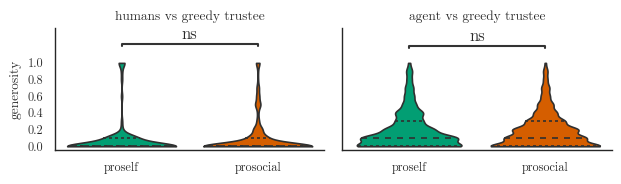

In [26]:
player = args['player']
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')
tTestAndPlot(emp, sim, args, 'generosity')

In [23]:
generalizePlot(pop, sim, args)

In [56]:
# for agent in pop:
#     aid = agent.ID
#     print(agent.ID, agent.w_i, agent.w_o)
#     print(sim.query("ID==@aid")['orientation'].unique())

# IBL vs Greedy Trustee

In [10]:
params = {
    "architecture": "IBL",
    "player": "investor",
    "opponent": "greedy",
    "nAgents": 300,
    "nIter": 3,
    'nGames': 15,
    "explore": 'exponential',
    "update": 'Q-learning',
    "w_s": 1,
    "w_o": 0.3,
    "w_i": 0.3,
    "nFinal": 3,
    "optimize_target": 'final',
    'overlap_test': 'rmse',
    "popSize": 40,
    "thrSVO": 0.2,
}
    
params2 = {
    "popSeed": 430,
    "decay": 0.78,
    "sigma": 0.34,
    "thrA": -1.71,
    "tau": 8,
    "gamma": 0.31
}

args = params | params2

In [4]:
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]

rng = args['popSeed']
dfs = []
for i in range(args['nIter']+1):
    for agent in agents: agent.reinitialize(args['player'])
    df = run(agents, nGames=args['nGames'], opponent=args["opponent"], t4tSeed=i).query("ID in @IDs")
    df['t4tSeed'] = [i for _ in range(df.shape[0])]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

In [12]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
sim.to_pickle(f"data/{params['architecture']}_vs_greedy_trustee_violin.pkl")

125 agents selected
proself 36, prosocial 89


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.364e-02 t=1.930e+00


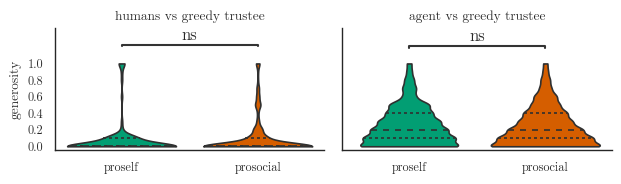

In [13]:
player = args['player']
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')
tTestAndPlot(emp, sim, args, 'generosity')

In [77]:
retestAndPlot(pop, sim, args)